In [1]:
#%pip install pybamm -q    # install PyBaMM if it is not installed
import os
import matplotlib.pyplot as plt
import numpy as np
import pybamm
import pandas as pd
import timeit
from matplotlib import style
style.use('ggplot')
start = timeit.default_timer()
os.chdir(pybamm.__path__[0]+'/..')
pybamm.set_logging_level("INFO")

In [2]:
model = pybamm.lithium_ion.BasicDFNComposite()
chemistry = pybamm.parameter_sets.Chen2020_composite
param = pybamm.ParameterValues(chemistry=chemistry)

# model = pybamm.lithium_ion.DFN()
# model = pybamm.lithium_ion.BasicDFN()
# chemistry = pybamm.parameter_sets.Chen2020
# param = pybamm.ParameterValues(chemistry=chemistry)
v_si=0.02
param.update({"Upper voltage cut-off [V]": 4.5})
param.update({"Lower voltage cut-off [V]": 2.5})
param.update({
    "Maximum concentration in negative electrode of phase 1 [mol.m-3]":28700,
    "Initial concentration in negative electrode of phase 1 [mol.m-3]":23000,
    "Negative electrode mass fraction of phase 1":1 - v_si,
    "Negative electrode diffusivity of phase 1 [m2.s-1]":5.5E-14,
    "Negative electrode diffusivity of phase 2 [m2.s-1]":1.67E-14,
    "Negative electrode mass fraction of phase 2":v_si,
    "Initial concentration in negative electrode of phase 2 [mol.m-3]":277000,
    "Maximum concentration in negative electrode of phase 2 [mol.m-3]":278000,
#     #
#     "Maximum concentration in negative electrode of phase 1 [mol.m-3]":33133,
#     "Initial concentration in negative electrode of phase 1 [mol.m-3]":29866,
#     "Negative electrode mass fraction of phase 1":1,
#     "Negative electrode diffusivity of phase 1 [m2.s-1]":3.3E-14,
#     "Negative electrode mass fraction of phase 2":0.00,
#     "Initial concentration in negative electrode of phase 2 [mol.m-3]":275220,
#     #
    })
param05 = param
param1 = param
param15 = param

# initial concentration of graphite 29866 [mol.m-3]
# -> 0.934 * 25830 + 0.0866 * 275220

C_rates = 0.5
Q_cell = 5 # [Ah]
#period = 1 / C_rates * Q_cell / 5 * 1.3
period = 7084 / 3600
transition = period / 20
timestep=np.array([0.1, period, 0]) * 3600
points=[41, 201, 201]
t_evals=[]
t0 = 0
for i in range(0,len(timestep)):
    t1 = np.linspace(t0, t0 + timestep[i] - transition, points[i])
    t0 += timestep[i]
    if i < len(timestep)-1:
        t2 = np.linspace(t0 - transition, t0 + transition, 41) # transition points
    else:
        t2 = []
    t_evals=np.concatenate((t_evals, t1 ,t2))

t_evals = np.unique(t_evals)
capacity = param["Nominal cell capacity [A.h]"]
I_load = C_rates * capacity  

def I_fun(A):
    def current(t):
        C_rates = 0.5
        Q_cell = 5 # [Ah]
        # period = 1 / C_rates * Q_cell / 5 * 1.3
        period = 7084.80 / 3600
        timestep=np.array([0.1, period, 2]) * 3600
        k = 10
        rest = pybamm.sigmoid( t , timestep[0], k)
        discharge = pybamm.sigmoid( t , timestep[0] + timestep[1], k) - rest
        return A * discharge
        # return A * (t < period) - A * (t >= period)
        # return A * 0.2 * pybamm.sin(2 * np.pi * t / 7200 )
    return current

param05["Current function [A]"] = I_fun(I_load)

sim1 = pybamm.Simulation(
    model,
    parameter_values=param05,
    solver=pybamm.CasadiSolver(dt_max = 10),
)
solution05_1 = sim1.solve(t_eval = t_evals)


new_model = model.set_initial_conditions_from(solution05_1, inplace=False)
param05_2=param05
param05_2["Current function [A]"] = 0
sim2 = pybamm.Simulation(
    new_model, parameter_values=param05_2, solver=pybamm.CasadiSolver(dt_max = 10)
)
t_evals2=solution05_1["Time [s]"].entries[-1]+np.arange(0,7200,5)
solution05_2=sim2.solve(t_eval = t_evals2)
solution05=[solution05_1,solution05_2]
stop = timeit.default_timer()
print("running time: " + str(stop - start) + "s")

2021-08-21 20:15:53,815 - [INFO] parameter_values.process_model(411): Start setting parameters for Doyle-Fuller-Newman model
2021-08-21 20:15:54,003 - [INFO] parameter_values.process_model(501): Finish setting parameters for Doyle-Fuller-Newman model
2021-08-21 20:15:54,006 - [INFO] discretisation.process_model(137): Start discretising Doyle-Fuller-Newman model
2021-08-21 20:15:54,610 - [INFO] discretisation.process_model(239): Finish discretising Doyle-Fuller-Newman model
2021-08-21 20:15:54,611 - [INFO] base_solver.solve(554): Start solving Doyle-Fuller-Newman model with CasADi solver with 'safe' mode
2021-08-21 20:15:54,613 - [INFO] base_solver.set_up(140): Start solver set-up
2021-08-21 20:15:54,799 - [INFO] base_solver.set_up(426): Finish solver set-up
2021-08-21 20:16:06,985 - [INFO] base_solver.solve(802): Finish solving Doyle-Fuller-Newman model (event: Minimum voltage)
2021-08-21 20:16:06,986 - [INFO] base_solver.solve(811): Set-up time: 187.082 ms, Solve time: 11.419 s (of wh

running time: 83.3712751000021s


In [3]:
## for 1 C discharge
C_rates = 1
Q_cell = 5 # [Ah]
#period = 1 / C_rates * Q_cell / 5 * 1.3
period = 3544.56 / 3600
transition = period / 20
timestep=np.array([0.1, period, 0]) * 3600
points=[41, 201, 201]
t_evals=[]
t0 = 0
for i in range(0,len(timestep)):
    t1 = np.linspace(t0, t0 + timestep[i] - transition, points[i])
    t0 += timestep[i]
    if i < len(timestep)-1:
        t2 = np.linspace(t0 - transition, t0 + transition, 41) # transition points
    else:
        t2 = []
    t_evals=np.concatenate((t_evals, t1 ,t2))

t_evals = np.unique(t_evals)
capacity = param["Nominal cell capacity [A.h]"]
I_load = C_rates * capacity  

def I_fun(A):
    def current(t):
        C_rates = 1
        Q_cell = 5 # [Ah]
        #period = 1 / C_rates * Q_cell / 5 * 1.3
        period = 3544.56 / 3600
        timestep=np.array([0.1, period, 0]) * 3600
        k = 5
        rest = pybamm.sigmoid( t , timestep[0], k)
        discharge = pybamm.sigmoid( t , timestep[0] + timestep[1], k) - rest
        return A * discharge
        # return A * (t < period) - A * (t >= period)
        # return A * 0.2 * pybamm.sin(2 * np.pi * t / 7200 )
    return current

param1["Current function [A]"] = I_fun(I_load)

sim1 = pybamm.Simulation(
    model,
    parameter_values=param1,
    solver=pybamm.CasadiSolver(dt_max = 10),
)
solution1_1 = sim1.solve(t_eval = t_evals)

new_model = model.set_initial_conditions_from(solution1_1, inplace=False)
param1_2=param1
param1_2["Current function [A]"] = 0
sim2 = pybamm.Simulation(
    new_model, parameter_values=param1_2, solver=pybamm.CasadiSolver(dt_max = 10)
)
t_evals2=solution1_1["Time [s]"].entries[-1]+np.arange(0,7200,5)
solution1_2=sim2.solve(t_eval = t_evals2)
solution1=[solution1_1,solution1_2]
stop = timeit.default_timer()
print("running time: " + str(stop - start) + "s")

2021-08-21 20:17:17,061 - [INFO] parameter_values.process_model(411): Start setting parameters for Doyle-Fuller-Newman model
2021-08-21 20:17:17,303 - [INFO] parameter_values.process_model(501): Finish setting parameters for Doyle-Fuller-Newman model
2021-08-21 20:17:17,306 - [INFO] discretisation.process_model(137): Start discretising Doyle-Fuller-Newman model
2021-08-21 20:17:17,863 - [INFO] discretisation.process_model(239): Finish discretising Doyle-Fuller-Newman model
2021-08-21 20:17:17,864 - [INFO] base_solver.solve(554): Start solving Doyle-Fuller-Newman model with CasADi solver with 'safe' mode
2021-08-21 20:17:17,867 - [INFO] base_solver.set_up(140): Start solver set-up
2021-08-21 20:17:18,027 - [INFO] base_solver.set_up(426): Finish solver set-up
2021-08-21 20:17:31,684 - [INFO] base_solver.solve(802): Finish solving Doyle-Fuller-Newman model (event: Minimum voltage)
2021-08-21 20:17:31,685 - [INFO] base_solver.solve(811): Set-up time: 161.974 ms, Solve time: 12.860 s (of wh

running time: 180.4780853000011s


In [4]:
## for 1.5 C charge
C_rates = 1.5
Q_cell = 5 # [Ah]
#period = 1 / C_rates * Q_cell / 5 * 1.3
period = 2360.23 / 3600
transition = period / 20
timestep=np.array([0.1, period, 0]) * 3600
points=[41, 201, 201]
t_evals=[]
t0 = 0
for i in range(0,len(timestep)):
    t1 = np.linspace(t0, t0 + timestep[i] - transition, points[i])
    t0 += timestep[i]
    if i < len(timestep)-1:
        t2 = np.linspace(t0 - transition, t0 + transition, 41) # transition points
    else:
        t2 = []
    t_evals=np.concatenate((t_evals, t1 ,t2))

t_evals = np.unique(t_evals)
capacity = param["Nominal cell capacity [A.h]"]
I_load = C_rates * capacity  

def I_fun(A):
    def current(t):
        C_rates = 1.5
        Q_cell = 5 # [Ah]
        #period = 1 / C_rates * Q_cell / 5 * 1.3
        period = 2360.23 / 3600
        timestep=np.array([0.1, period, 0]) * 3600
        k = 5
        rest = pybamm.sigmoid( t , timestep[0], k)
        discharge = pybamm.sigmoid( t , timestep[0] + timestep[1], k) - rest
        return A * discharge
        # return A * (t < period) - A * (t >= period)
        # return A * 0.2 * pybamm.sin(2 * np.pi * t / 7200 )
    return current

param15["Current function [A]"] = I_fun(I_load)

sim1 = pybamm.Simulation(
    model,
    parameter_values=param15,
    solver=pybamm.CasadiSolver(dt_max = 10),
)
solution1_5_1 = sim1.solve(t_eval = t_evals)

new_model = model.set_initial_conditions_from(solution1_5_1, inplace=False)
param15_2=param15
param15_2["Current function [A]"] = 0
sim2 = pybamm.Simulation(
    new_model, parameter_values=param15_2, solver=pybamm.CasadiSolver(dt_max = 10)
)
t_evals2=solution1_5_1["Time [s]"].entries[-1]+np.arange(0,7200,5)
solution1_5_2=sim2.solve(t_eval = t_evals2)
solution1_5=[solution1_5_1,solution1_5_2]
stop = timeit.default_timer()
print("running time: " + str(stop - start) + "s")

2021-08-21 20:18:54,149 - [INFO] parameter_values.process_model(411): Start setting parameters for Doyle-Fuller-Newman model
2021-08-21 20:18:54,392 - [INFO] parameter_values.process_model(501): Finish setting parameters for Doyle-Fuller-Newman model
2021-08-21 20:18:54,394 - [INFO] discretisation.process_model(137): Start discretising Doyle-Fuller-Newman model
2021-08-21 20:18:55,003 - [INFO] discretisation.process_model(239): Finish discretising Doyle-Fuller-Newman model
2021-08-21 20:18:55,003 - [INFO] base_solver.solve(554): Start solving Doyle-Fuller-Newman model with CasADi solver with 'safe' mode
2021-08-21 20:18:55,006 - [INFO] base_solver.set_up(140): Start solver set-up
2021-08-21 20:18:55,163 - [INFO] base_solver.set_up(426): Finish solver set-up
2021-08-21 20:19:11,150 - [INFO] base_solver.solve(802): Finish solving Doyle-Fuller-Newman model (event: Minimum voltage)
2021-08-21 20:19:11,151 - [INFO] base_solver.solve(811): Set-up time: 160.399 ms, Solve time: 15.212 s (of wh

running time: 397.2216087000015s


In [5]:
# plot
plot = pybamm.QuickPlot( solution05, [       
        "Current [A]",
        "Terminal voltage [V]",
        "X-averaged negative electrode open circuit potential of phase 1 [V]",
        "X-averaged negative electrode open circuit potential of phase 2 [V]",
    ]
)
plot.dynamic_plot()


interactive(children=(FloatSlider(value=0.0, description='t', max=4.047981044270563, step=0.040479810442705634…

In [6]:
path = "wip/data/chen/"
V_0_5C_exp=pd.read_csv (path + "0.5C_exp.csv", delimiter= ',',header=None)
V_0_5C_sim=pd.read_csv (path + "0.5C_sim.csv", delimiter= ',',header=None)
V_1C_exp=pd.read_csv (path + "1C_exp.csv", delimiter= ',',header=None)
V_1C_sim=pd.read_csv (path + "1C_sim.csv", delimiter= ',',header=None)
V_1_5C_exp=pd.read_csv (path + "1.5C_exp.csv", delimiter= ',',header=None)
V_1_5C_sim=pd.read_csv (path + "1.5C_sim.csv", delimiter= ',',header=None)

t_all0_5C = np.concatenate((solution05[0]["Time [s]"].entries,solution05[1]["Time [s]"].entries),axis=0) / 3600
V_n0_5C = np.concatenate((solution05[0]["Terminal voltage [V]"].entries,solution05[1]["Terminal voltage [V]"].entries))
t_all1C = np.concatenate((solution1[0]["Time [s]"].entries, solution1[1]["Time [s]"].entries ))/ 3600
V_n1C = np.concatenate((solution1[0]["Terminal voltage [V]"].entries, solution1[1]["Terminal voltage [V]"].entries))
t_all1_5C = np.concatenate((solution1_5[0]["Time [s]"].entries, solution1_5[1]["Time [s]"].entries)) / 3600
V_n1_5C = np.concatenate((solution1_5[0]["Terminal voltage [V]"].entries, solution1_5[1]["Terminal voltage [V]"].entries))

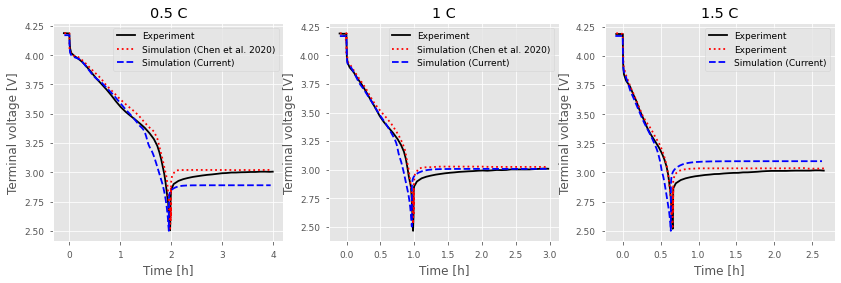

In [7]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3 ,figsize=(14,4))
ax1.plot(V_0_5C_exp.values[:,0], V_0_5C_exp.values[:,1],'k-',label="Experiment")
ax1.plot(V_0_5C_sim.values[:,0], V_0_5C_sim.values[:,1],'r:',label="Simulation (Chen et al. 2020)")
ax1.plot(t_all0_5C - 0.1, V_n0_5C ,'b--',label="Simulation (Current)")
ax1.set_title('0.5 C')
ax1.set_xlabel('Time [h]')
ax1.set_ylabel('Terminal voltage [V]')
ax1.legend()

ax2.plot(V_1C_exp.values[:,0], V_1C_exp.values[:,1],'k-',label="Experiment")
ax2.plot(V_1C_sim.values[:,0], V_1C_sim.values[:,1],'r:',label="Simulation (Chen et al. 2020)")
ax2.plot(t_all1C - 0.1, V_n1C ,'b--',label="Simulation (Current)")
ax2.set_title('1 C')
ax2.set_xlabel('Time [h]')
ax2.set_ylabel('Terminal voltage [V]')
ax2.legend()

ax3.plot(V_1_5C_exp.values[:,0], V_1_5C_exp.values[:,1],'k-',label="Experiment")
ax3.plot(V_1_5C_sim.values[:,0], V_1_5C_sim.values[:,1],'r:',label="Experiment")
ax3.plot(t_all1_5C - 0.1, V_n1_5C ,'b--',label="Simulation (Current)")
ax3.set_title('1.5 C')
ax3.set_xlabel('Time [h]')
ax3.set_ylabel('Terminal voltage [V]')
ax3.legend()

[0.11585156284331816, 0.12280428900179567, 0.1547075870879831]
[0.057638798234578195, 0.05450319946419923, 0.05531997934065868]


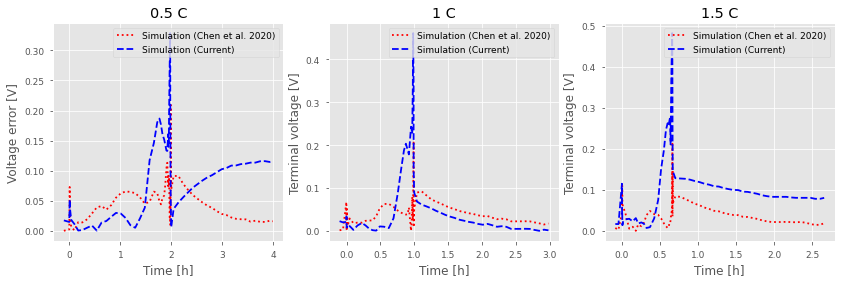

In [8]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3 ,figsize=(14,4))
# ax1.plot(V_0_5C_exp.values[:,0], V_0_5C_exp.values[:,1],'k-',label="Experiment")
V_exp1 = np.interp(V_0_5C_exp.values[:,0], V_0_5C_sim.values[:,0], V_0_5C_sim.values[:,1])
ax1.plot(V_0_5C_exp.values[:,0], abs(V_0_5C_exp.values[:,1] - V_exp1),'r:',label="Simulation (Chen et al. 2020)")
V_exp2 = np.interp(V_0_5C_exp.values[:,0],t_all0_5C - 0.1, V_n0_5C)
ax1.plot(V_0_5C_exp.values[:,0], abs(V_0_5C_exp.values[:,1] - V_exp2) ,'b--',label="Simulation (Current)")
ax1.set_title('0.5 C')
ax1.set_xlabel('Time [h]')
ax1.set_ylabel('Voltage error [V]')
ax1.legend()
RMSE_0_5C = np.sqrt(((V_0_5C_exp.values[:,1] - V_exp2) ** 2 ).mean())
RMSE_0_5C_chen = np.sqrt(((V_0_5C_exp.values[:,1] - V_exp1) ** 2 ).mean())

#ax2.plot(V_1C_exp.values[:,0], V_1C_exp.values[:,1],'k-',label="Experiment")
V_exp1 = np.interp(V_1C_exp.values[:,0], V_1C_sim.values[:,0], V_1C_sim.values[:,1])
ax2.plot(V_1C_exp.values[:,0], abs(V_1C_exp.values[:,1] - V_exp1),'r:',label="Simulation (Chen et al. 2020)")
V_exp2 = np.interp(V_1C_exp.values[:,0], t_all1C - 0.1, V_n1C)
ax2.plot(V_1C_exp.values[:,0], abs(V_1C_exp.values[:,1] - V_exp2),'b--',label="Simulation (Current)")
ax2.set_title('1 C')
ax2.set_xlabel('Time [h]')
ax2.set_ylabel('Terminal voltage [V]')
ax2.legend()
RMSE_1C = np.sqrt(((V_1C_exp.values[:,1] - V_exp2) ** 2 ).mean())
RMSE_1C_chen = np.sqrt(((V_1C_exp.values[:,1] - V_exp1) ** 2 ).mean())

#ax3.plot(V_1_5C_exp.values[:,0], V_1_5C_exp.values[:,1],'k-',label="Experiment")
V_exp1 = np.interp(V_1_5C_exp.values[:,0], V_1_5C_sim.values[:,0], V_1_5C_sim.values[:,1])
ax3.plot(V_1_5C_exp.values[:,0], abs(V_1_5C_exp.values[:,1] - V_exp1),'r:',label="Simulation (Chen et al. 2020)")
V_exp2 = np.interp(V_1_5C_exp.values[:,0], t_all1_5C - 0.1, V_n1_5C)
ax3.plot(V_1_5C_exp.values[:,0], abs(V_1_5C_exp.values[:,1] - V_exp2) ,'b--',label="Simulation (Current)")
ax3.set_title('1.5 C')
ax3.set_xlabel('Time [h]')
ax3.set_ylabel('Terminal voltage [V]')
ax3.legend()
RMSE_1_5C = np.sqrt(((V_1_5C_exp.values[:,1] - V_exp2) ** 2 ).mean())
RMSE_1_5C_chen = np.sqrt(((V_1_5C_exp.values[:,1] - V_exp1) ** 2 ).mean())
print([RMSE_0_5C, RMSE_1C, RMSE_1_5C])
print([RMSE_0_5C_chen, RMSE_1C_chen, RMSE_1_5C_chen])

In [9]:
# save all data
headstr="time, voltage for 0.5C in current simulation"
outputs=[t_all0_5C - 0.1, V_n0_5C]
np.savetxt('wip/data/composite_0.5C_current.txt', outputs, delimiter=',', header=headstr,fmt='%1.6f')  

# save all data
headstr="time, voltage for 1C in current simulation"
outputs=[t_all1C - 0.1, V_n1C]
np.savetxt('wip/data/composite_1C_current.txt', outputs, delimiter=',', header=headstr,fmt='%1.6f') 

# save all data
headstr="time, voltage for 0.5C in current simulation"
outputs=[t_all1_5C - 0.1, V_n1_5C]
np.savetxt('wip/data/composite_1.5C_current.txt', outputs, delimiter=',', header=headstr,fmt='%1.6f')  

In [10]:
return

SyntaxError: 'return' outside function (<ipython-input-10-9b32c1431b19>, line 1)

In [ ]:
times = solution1_5["Time [s]"].entries / 3600
c_s_xrav_n_p1 = solution1_5["Averaged negative electrode concentration of phase 1"].entries
c_s_xrav_n_p2 = solution1_5["Averaged negative electrode concentration of phase 2"].entries
c_s_xrav_p = solution1_5["Averaged positive electrode concentration"].entries
plt.plot(times, c_s_xrav_n_p1,'r-', label='Graphite')
plt.plot(times, c_s_xrav_n_p2, 'b:',label='Silicon')
plt.plot(times, c_s_xrav_p, 'g--',label='NMC')
plt.xlabel("Time [h]")
plt.ylabel("$c/c_\mathrm{max}$")
# plt.ylim([0,0.02])
plt.legend()

In [ ]:
times = solution1_5["Time [s]"].entries / 3600
ocp_p1 = solution1_5["X-averaged negative electrode open circuit potential of phase 1 [V]"].entries
ocp_p2 = solution1_5["X-averaged negative electrode open circuit potential of phase 2 [V]"].entries
plt.plot(times,ocp_p1,'r--',label='Graphite')
plt.plot(times,ocp_p2,'b:',label='Silicon')
plt.xlabel("Time [h]")
plt.ylabel("Open circuit potential [V]")
plt.title("Cell open circuit potential [V]")
plt.legend()
# plt.xlim([100, 103])
# plt.ylim([0.4, 1])

In [ ]:
j_n_p1_av = solution1_5["X-averaged negative electrode interfacial current density of phase 1 [A.m-2]"].entries
j_n_p2_av = solution1_5["X-averaged negative electrode interfacial current density of phase 2 [A.m-2]"].entries
plt.plot(times, j_n_p1_av,'r-', label='Graphite')
plt.plot(times, j_n_p2_av, 'b:',label='Silicon')
plt.xlabel("Time [h]")
plt.ylabel("Interfacial current density [A/m$^{2}$]")
# plt.ylim([-0.2, 0.8])
plt.xlim([0.7, 0.8])
plt.legend()

In [ ]:
print(V_1_5C_exp.values[:,1] - V_exp1)

In [ ]:
print(solution1_5_1)

In [ ]:
solution10=solution1_5_1.append(solution1_5_2)

In [ ]:
solution10=np.concatenate(solution1_5_1,solution1_5_2)